# Датасет MNIST

*MNIST* — набор изображений рукописных цифр:

- Он содержит 60 000 обучающих и 10 000 тестовых изображений.
- Размер каждого изображения — 28×28 пикселей в оттенках серого.
- Набор охватывает 10 классов — цифры от 0 до 9. 
- Изображения хранятся как непрерывные матрицы пикселей с интенсивностью от 0 до 255, а метки — как целочисленные значения от 0 до 9.

*Достоинства MNIST.* Набор простой, небольшого размера и имеет стабильные статистические характеристики. 

Благодаря этому он быстро стал популярен для исследований в области глубокого обучения и компьютерного зрения. 

Сейчас, спустя более 30 лет с момента его официального представления, с его помощью проведено большое количество исследований. Результаты новых экспериментов легко сравнить с результатами опубликованных работ и реализованных систем. 

В итоге MNIST превратился в универсальный эталон, задающий «точку входа» в глубокое обучение, — именно на нём часто учатся готовить данные, строить и тренировать MLP, прежде чем перейти к более сложным наборам и архитектурам.

*Зачем используют.* Сейчас точность лучших моделей приближается к 100% и MNIST уже не считается сложной задачей. Но он по-прежнему идеален для старта, поскольку с его помощью легко понять:

- Как готовить реальные изображения к обучению MLP (не только плоские векторы искусственных данных).
- Зачем и как нормализовать входы нейросети, чтобы ускорить сходимость и повысить стабильность обучения.
- Как разбить данные на обучающую и валидационную выборки, организовать поток данных через DataLoader и подготовить инфраструктуру для дальнейшего эксперимента.

*Где используют.* С MNIST часто начинают в таких сферах:

- **Обучение.** Новички отрабатывают базовые концепции: Flatten, Linear, ReLU, нормализацию, DataLoader.
- **Сравнительные исследования.** MNIST позволяет объективно оценивать новые архитектуры и приёмы регуляризации.
- **Разработка производительных тестов для библиотек и аппаратных платформ (GPU, TPU)**. MNIST удобен, так как быстро обрабатывается даже на CPU.

В этом уроке мы подготовим и изучим данные. План такой:

- Загрузим датасет через `torchvision.datasets.MNIST.`
- Настроим трансформации: превратим изображения из PIL в тензоры, масштабируем пиксели в диапазон [0,1] и выполним стандартизацию (`normalize`).
- Визуализируем отдельные примеры, чтобы убедиться в корректности загрузки и понять, с чем мы работаем.
- Разобьём обучающую выборку на тренировочный и валидационный наборы с помощью `random_split`.
- Соберём `DataLoader`, чтобы эффективно формировать мини-батчи при обучении и валидации.

# MLP для изображений

`MLP` принимает на вход вектор, поэтому теоретически его можно применить к изображениям.

Для этого достаточно сначала «развернуть» матрицу пикселей в вектор. Например, изображение 28×28 превращается в вектор длины 28×28=784.

![MLP for MNIST](data/Image.png)

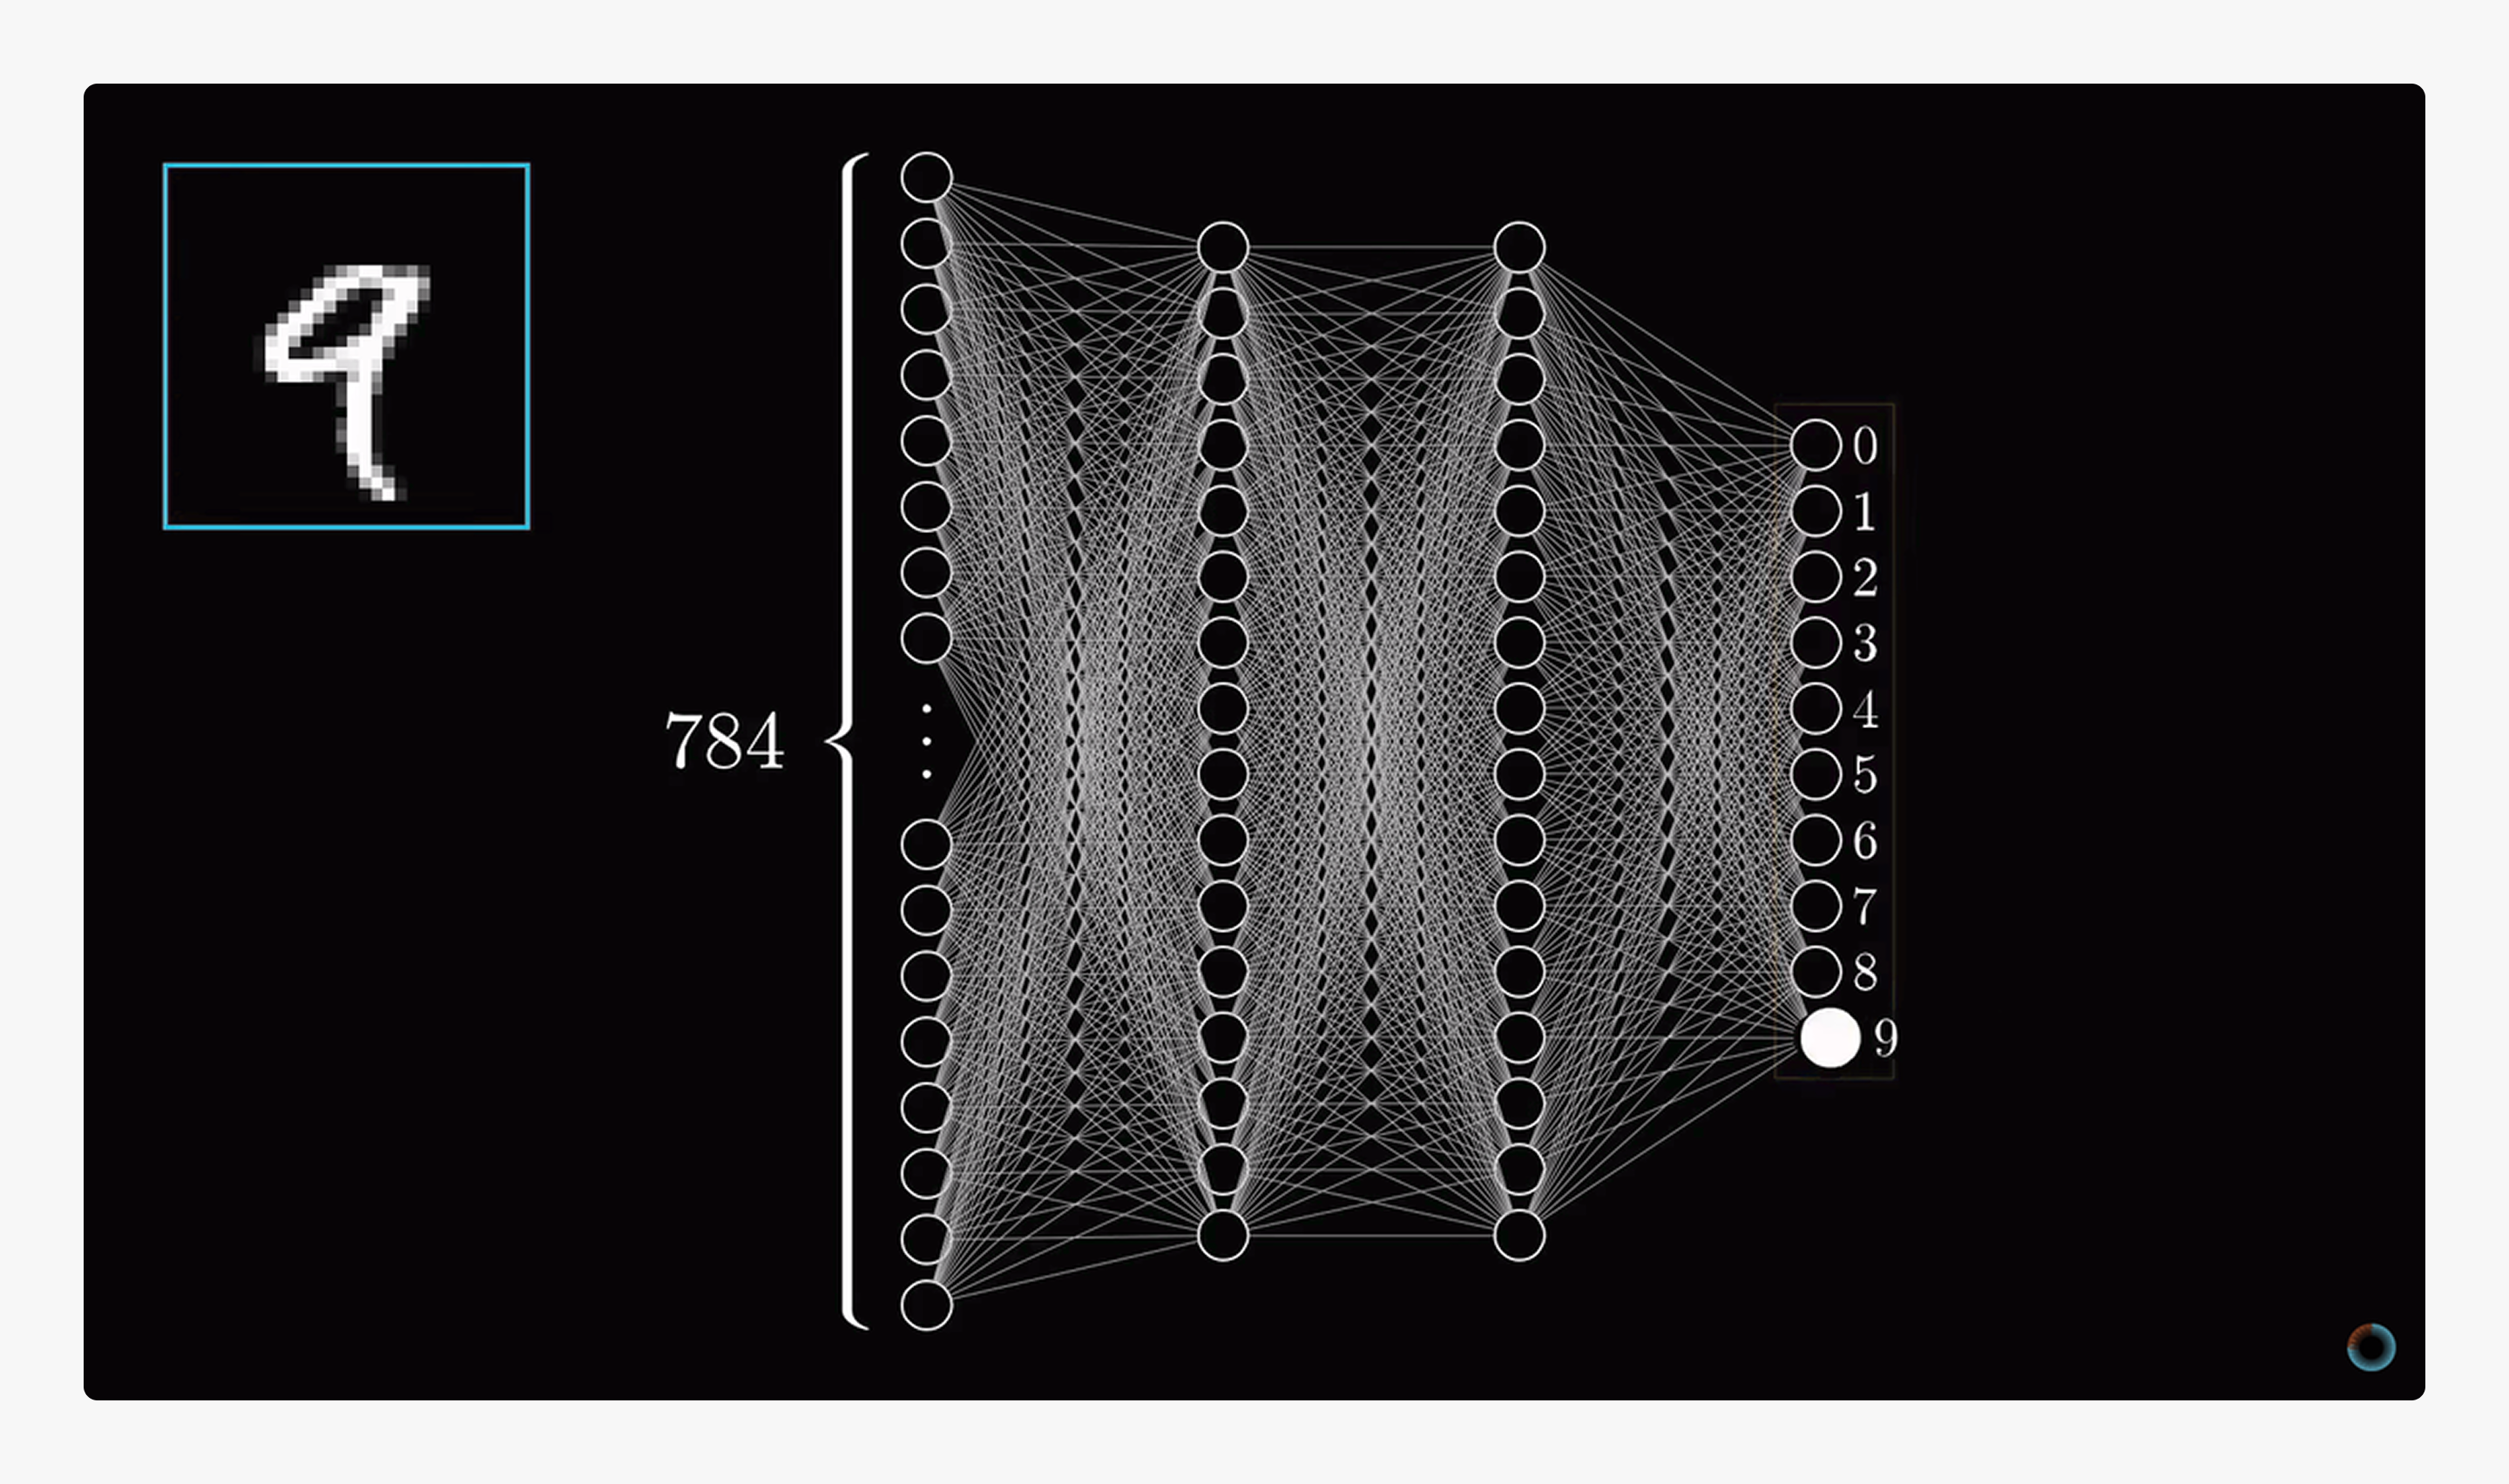

In [5]:
# Как еще можно отобразить изображение:
from IPython.display import Image

Image("/home/ollldman/Programms/ml_dl_experiments/dl/dl_modules/2. second_theme_PyTorch/data/Image.png", width=600, height=1000)

На этой схеме показан классический пример: весь двумерный массив пикселей «раскатывается» в одномерный вектор длиной 784. 

Эти 784 числа становятся входными признаками для `MLP`. На первом скрытом слое множество нейронов, каждый из которых связан со всеми 784 входными признаками. И второй скрытый слой снова полносвязная прослойка — каждый нейрон второго слоя соединён с каждым нейроном первого слоя (N₁×N₂ параметров). В конце на выходном слое получаем 10 нейронов — по одному на каждый класс цифр от 0 до 9. Нейрон с наибольшим выходным значением определяет предсказанную цифру (в примере это нейрон «9»).
Такой подход можно реализовать, но у него есть ограничения: 

- У полносвязной сети число параметров растёт пропорционально количеству входов×выходов и весов становится очень много.
- MLP просто обрабатывает длинный вектор значений и «не видит» двумерной структуры изображения — связи игнорируют местную структуру картинки.

Поэтому в общем случае MLP неэффективен для сложных изображений. Но для небольших данных (как MNIST) MLP всё же может дать приемлемую точность.

# Flatten и нормализация

Чтобы подать изображение в MLP, нужно выполнить два шага: 

1. **Преобразовать данные в одномерный тензор (flatten).** В PyTorch для этого можно использовать `tensor.view(-1)` или модуль `nn.Flatten`.

``` python
import torch

import torch.nn as nn

from torchvision import transforms


# img: тензор формы [1, 28, 28]
x_flat = img.view(-1)        # формы [784]
# или с помощью nn.Flatten()
flatten = nn.Flatten()
x_flat = flatten(img)        # формы [1, 784] 
```

В этом примере каждая ячейка матрицы становится одним входным нейроном. 

2. **Нормализовать данные**, то есть привести каждый канал к нулевому среднему и единичному стандартному отклонения. На практике для `MNIST` часто используют `transforms.Normalize((0.1307,), (0.3081,))`, так как глобальное среднее равно примерно `0.1307`, а стандартное отклонение — `0.3081`.
Нормализация убирает большие перекосы и смещение данных, тем самым ускоряет и стабилизирует обучение.

## Загрузка датасета

Загрузим MNIST через torchvision.datasets.MNIST. Укажем download=True, чтобы данные автоматически загрузились и распаковались (они сохранятся в папке ./data):

```python

from torchvision.datasets import MNIST


train_data = MNIST(root='./data', train=True, download=True, transform=None)
test_data  = MNIST(root='./data', train=False, download=True, transform=None)
```

Здесь train_data и test_data — объекты, содержащие изображения и метки. 

## Трансформации

Определим преобразования: 

- сначала ToTensor(), чтобы сконвертировать PIL-изображение в torch.Tensor с пикселями [0,1],
- затем Normalize для стандартизации:

```python

import torchvision.transforms as transforms

from torchvision.datasets import MNIST


transform = transforms.Compose([
    transforms.ToTensor(),                     # из [0,255] в [0,1]
    transforms.Normalize((0.1307,), (0.3081,)) # нормализация (mean=0.1307,std=0.3081)
    # Значения вычислены по всему тренировочному набору MNIST и помогают привести данные к нулевому среднему и единичному стандартному отклонению, что ускоряет и стабилизирует обучение.
])


train_data = MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = MNIST(root='./data', train=False, download=True, transform=transform)
```

После этого train_data\[i\]\[0\] — это тензор размера \[1,28,28\] (одно изображение) с типом float32, а train_data\[i\]\[1\] — метка (целое число от 0 до 9).

In [2]:
import torch
print(torch.cuda.is_available())

True


/home/ollldman/.cache/pypoetry/virtualenvs/ml-dl-experiments-m4qsJGWw-py3.13/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 9.91M/9.91M [00:03<00:00, 3.14MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 225kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 17.4MB/s]


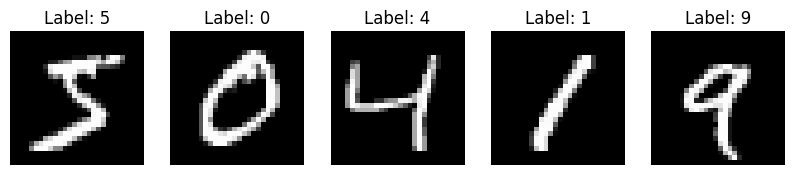

In [4]:
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import MNIST

from ml_dl_experiments.settings import settings

path_to_load: str = settings.SOURCE_PATH + "/ml_dl/second_theme_data/"
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.1307], std=[0.3081])
])


train_data = MNIST(root=path_to_load,
                    train=True,
                    download=True, 
                    transform=transform)
test_data  = MNIST(root=path_to_load,
                    train=False,
                    download=True, 
                    transform=transform)


# Блок кода, отвечающий за визуализацию, его редактировать не надо.
fig, axes = plt.subplots(1, 5, figsize=(10,2))
for i, ax in enumerate(axes):
    img, label = train_data[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

Разобъем данные на тренировочные и валидационные:

images.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
Метка первого изображения в батче: 8


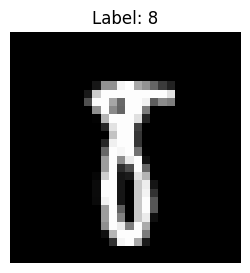

In [5]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import v2
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader

from ml_dl_experiments.settings import settings

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1307], std=[0.3081])
])

path_to_load: str = settings.SOURCE_PATH + "/ml_dl/second_theme_data/"
# try:
train_data = MNIST(root=path_to_load,
                    train=True,
                    download=False,
                    transform=transform)
test_data  = MNIST(root=path_to_load,
                    train=False,
                    download=True,
                    transform=transform)
# except Exception as e:
#     print(e)
#     exit()

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data,
                          batch_size=64,
                          shuffle=True)

val_loader = DataLoader(val_data,
                        batch_size=64,
                        shuffle=False)

images, labels = next(iter(train_loader))


# Печатаем формы тензоров
print("images.shape:", images.shape)   # torch.Size([64, 1, 28, 28])
print("labels.shape:", labels.shape)   # torch.Size([64])


# Выведем метку первого изображения
first_label = labels[0].item()
print("Метка первого изображения в батче:", first_label)


# Отобразим само первое изображение
plt.figure(figsize=(3,3))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()